# Study Case 4 — AA3105-O: Variable Influence Screening

**Systematic Evaluation of Non-Chemical Variables Under Conservative Modeling Discipline**


This notebook operationalizes Study Case 4 (SC04) by implementing a disciplined screening process to evaluate whether commonly measured, metallurgically motivated process variables provide **meaningful and stable incremental value** beyond a frozen chemistry-only baseline.

This study demonstrates **what happens when you don't find improvement**—a valid and informative outcome when grounded in rigorous methodology.

Within the portfolio, SC04 functions as a negative result with high informational value:   

it defines where incremental complexity stops paying off, thereby preventing unjustified model escalation.

## Notebook Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Portfolio Analytics Toolkit
from portfolio_analytics_toolkit.io import load_public_dataset
from portfolio_analytics_toolkit.cv import build_oof_predictions, summarize_folds, metrics_by_fold
from portfolio_analytics_toolkit.metrics import metrics_from_oof, q_summary, iqr
from portfolio_analytics_toolkit.plots import (
    plot_study_window_histogram,
    plot_actual_vs_predicted,
    plot_residual_hist,
    plot_p95_abs_error_hbar,
    plot_mae_median_cv,
    plot_incremental_deltas,
    compare_error_distributions
)
from portfolio_analytics_toolkit.style import set_matplotlib_style

set_matplotlib_style('ggplot')

## 0. Executive Framing & Scope

**Study Case 4 (SC04)** evaluates whether commonly measured, metallurgically justified process variables provide **stable and defensible improvements** to a frozen chemistry-only baseline established in SC02.

### The Central Modeling Problem

In industrial manufacturing, variables are often measured because they are:
- **operationally important** (process control requires monitoring)
- **metallurgically relevant** (known physical mechanisms)

Operational importance does not guarantee modeling utility.
Only variables that reduce uncertainty under realistic validation
justify inclusion in predictive standards.

This study answers:
- **Which measured variables actually reduce predictive uncertainty and tail risk?**

### Scope & Key Assumptions

- **Baseline:** Chemistry-only Ridge model from SC02 (frozen, no retuning)
- **System:** AA3105-O (same as SC02)
- **Candidates:** Final thickness, reduction %, coiling temperature
- **Evaluation:** Rigorous, incremental screening with explicit non-improvement acceptance
- **Validation:** Group-aware OOF (prevents heat-level leakage)
- **Success criterion:** Stable reduction in **P95 absolute error** + **fold robustness**, not marginal MAE gains

## 1. Analytical Setup & Data Integrity

Data integrity checks mirror those applied in SC02 to ensure comparability and prevent grain-related leakage.

Only heat-level records are retained.

In [3]:
# =====================================================
# Study Scope & Global Parameters
# =====================================================

RANDOM_STATE = 42
N_SPLITS = 5
ALLOY_SYSTEM = ['3105']

# Chemistry baseline (frozen from SC02)
CHEM_COLS = ['mn', 'mg']

# Candidate process variables
PROCESS_COLS = ['final_thickness', 'coiling_temperature', 'reduction_pct']

# Target
TARGET_COL = 'uts_mpa'
GROUP_COL = 'heat_num'

print(f'Chemistry features (frozen): {CHEM_COLS}')
print(f'Process candidates: {PROCESS_COLS}')
print(f'Validation: {N_SPLITS}-fold GroupKFold by {GROUP_COL}')

Chemistry features (frozen): ['mn', 'mg']
Process candidates: ['final_thickness', 'coiling_temperature', 'reduction_pct']
Validation: 5-fold GroupKFold by heat_num


In [4]:
# =====================================================
# Data Loading & Grain Integrity Check
# =====================================================

required_cols = ['heat_num', 'uts_mpa', 'mn', 'mg', 'final_thickness', 'coiling_temperature', 'reduction_pct']

df = load_public_dataset(
    dataset_id_or_path='sc04',
    csv_name='v_models_analysis_o.csv'
)

df_model = df[required_cols].copy()
print(f'Total rows: {len(df_model)}')
print(f'Unique heats: {df_model['heat_num'].nunique()}')

Total rows: 2294
Unique heats: 2294


### Heat-Level Integrity Check

A critical grain check confirms **one-to-one correspondence** between heats and model rows, ensuring validation reflects generalization to unseen heats rather than repeated measurements.

In [5]:
# Grain check: one row per heat
rows_per_heat = df_model.groupby('heat_num').size()
print(f'\nGrain Integrity Check:')
print(f'  Max rows per heat: {rows_per_heat.max()}')
print(f'  Min rows per heat: {rows_per_heat.min()}')
print(f'  Mean rows per heat: {rows_per_heat.mean():.2f}')

assert rows_per_heat.max() == 1.0, 'GRAIN VIOLATED: Multiple rows per heat detected'
print('\n✓ Grain check PASSED: one row per heat confirmed')


Grain Integrity Check:
  Max rows per heat: 1
  Min rows per heat: 1
  Mean rows per heat: 1.00

✓ Grain check PASSED: one row per heat confirmed


### Distributional Overview

Basic distributional summaries verify plausible ranges and coverage of chemistry, process variables, and UTS.

In [6]:
# Chemistry domain
print('\n' + '='*60)
print('CHEMISTRY & TARGET DOMAIN (study window)')
print('='*60)

print('\nChemistry Features:')
display(df_model[CHEM_COLS].apply(q_summary).T)

print('\nTarget (UTS):')
display(df_model[[TARGET_COL]].apply(q_summary).T)

print('\nProcess Variables Domain:')
display(df_model[PROCESS_COLS].apply(q_summary).round(2).T)


CHEMISTRY & TARGET DOMAIN (study window)

Chemistry Features:


,min,p01,p50,p99,max
mn,0.295,0.313,0.441,0.60200,0.699
mg,0.200,0.202,0.432,0.71328,0.776



Target (UTS):


,min,p01,p50,p99,max
uts_mpa,99.0,107.0,122.0,140.0,144.0



Process Variables Domain:


,min,p01,p50,p99,max
final_thickness,0.61,0.64,2.00,4.03,4.08
coiling_temperature,200.00,280.00,319.00,340.00,387.00
reduction_pct,0.35,0.50,0.71,0.91,0.93


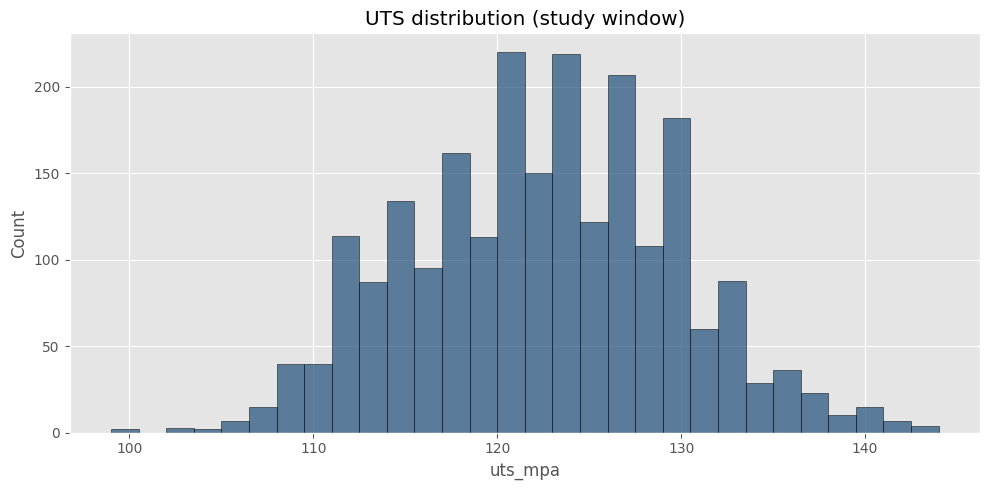

In [7]:
fig, ax = plot_study_window_histogram(df_model, TARGET_COL, palette=None)
plt.show()

## 2. Frozen Chemistry-Only Baseline

This section establishes and validates the **frozen baseline** from SC02. No retuning or adaptation is performed to any new variables.

### Critical Design Principle: Frozen baseline

The chemistry-only Ridge model is defined **once** and remains **frozen** throughout all screening steps. This ensures that:

1. Observed differences reflect **only the contribution of added variables**, not hyperparameter tuning
2. Any performance degradation is flagged as **meaningful**, not dismissed as tuning artifacts
3. Comparisons are **defensible and reproducible**

In [8]:
# =====================================================
# Baseline Model Definition (Frozen)
# =====================================================

baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

print('Frozen Chemistry-Only Baseline Model:')
print('  Features: Mn, Mg')
print('  Architecture: StandardScaler + Ridge(alpha=1.0)')
print('  Frozen: YES (no retuning for additional variables)')

Frozen Chemistry-Only Baseline Model:
  Features: Mn, Mg
  Architecture: StandardScaler + Ridge(alpha=1.0)
  Frozen: YES (no retuning for additional variables)


In [9]:
# =====================================================
# Baseline OOF Evaluation
# =====================================================

baseline_oof = build_oof_predictions(
    df=df_model,
    models={'ridge': baseline_model},
    feature_cols=CHEM_COLS,
    target_col=TARGET_COL,
    group_col=GROUP_COL,
    n_splits=N_SPLITS
)

baseline_metrics = metrics_from_oof(baseline_oof)

print('='*60)
print('Baseline Performance (Chemistry-Only Ridge, OOF):')
print('='*60)
baseline_metrics.round(3)

Baseline Performance (Chemistry-Only Ridge, OOF):


,model_id,n,mae,rmse,r2,p95_abs_error
0,ridge,2294,3.584,4.774,0.556,9.644


In [10]:
# Store baseline metrics for incremental comparison
baseline_row = baseline_metrics.loc[baseline_metrics['model_id'] == 'ridge'].iloc[0]
baseline_mae = baseline_row['mae']
baseline_p95 = baseline_row['p95_abs_error']
baseline_r2 = baseline_row['r2']

print(f'\n{' Baseline Reference Metrics ':=^60}')
print(f'  MAE:              {baseline_mae:.3f} MPa')
print(f'  P95 Abs Error:    {baseline_p95:.3f} MPa')
print(f'  R²:               {baseline_r2:.3f}')
print('='*60)
print('\nThese metrics define the error envelope that added variables must reduce.')


================ Baseline Reference Metrics ================
  MAE:              3.584 MPa
  P95 Abs Error:    9.644 MPa
  R²:               0.556

These metrics define the error envelope that added variables must reduce.


### Visual Validation of Baseline

Out-of-fold predictions from the baseline provide a visual check for systematic bias or compression.

                Chemistry-Only Baseline — Out-of-Fold Predictions


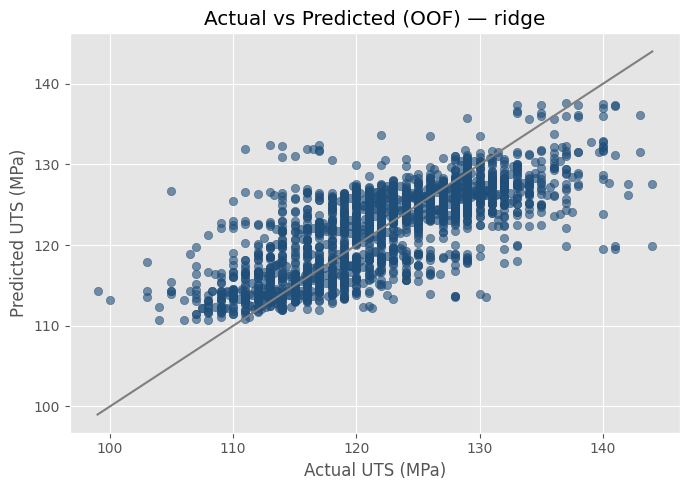

In [11]:
fig, ax = plot_actual_vs_predicted(baseline_oof, {'ridge': baseline_model})

print('='*81)
print(' ' * 16 + 'Chemistry-Only Baseline — Out-of-Fold Predictions')
print('='*81)
plt.tight_layout()
plt.show()

## 3. Candidate Variables: Metallurgical Rationale


Three process variables are evaluated, selected based on:
- **Routine measurement in production** (not speculative proxies)
- **Metallurgical mechanism** (known physical links to UTS)
- **Operational controllability** (not just observational)

### Feature Set Design Rationale

To isolate the marginal contribution of process information,
features are introduced **incrementally** on top of a frozen chemistry-only baseline.

This structure allows us to answer a specific question:

> Does each additional process proxy reduce uncertainty,
or does it merely reallocate error without improving robustness?

Each model variant is evaluated under the same group-aware
out-of-fold validation regime to ensure fair comparison.

### Variables Under Evaluation

| Variable | Type | Rationale | Typical Range |
|----------|------|-----------|---------------|
| **Final Thickness** | Deformation | Accumulated strain → strength via dislocation density | 0.61–4.0 mm |
| **Reduction %** | Deformation |  Cumulative plastic deformation (alt. encoding)| 35–93% |
| **Coiling Temperature** | Thermal | Recovery/recrystallization kinetics | 200–380°C |

### Important: Operational ≠ Modeling

A variable can be:
- **Operationally critical** (must measure and control) AND
- **Modeling irrelevant** (doesn't reduce prediction uncertainty)

This study addresses the second question only. We're not saying these variables don't matter; we're asking whether they **improve UTS prediction**.

### Hypothesis: Why We Might Expect Improvement

**Intuitive argument:**
- UTS depends on microstructure (grain size, dislocation density, precipitate state)
- Microstructure depends on: chemistry + deformation history + thermal history
- SC02 captures chemistry (Mn, Mg)
- Candidate variables capture deformation (thickness, %) and thermal (coiling_temp)
- → Therefore, shouldn't we improve?

## 4. Incremental Screening Design

Variables are evaluated using a **stepwise, incremental approach** where each configuration differs from the baseline by a single variable or representation.

All models use **identical validation strategy and data splits** to ensure differences reflect true incremental effects.

In [12]:
# =====================================================
# Feature Sets by Model (Stepwise Incremental)
# =====================================================

feature_sets = {
    'M0_chem': CHEM_COLS,
    'M1_thickness': CHEM_COLS + ['final_thickness'],
    'M1_reduction': CHEM_COLS + ['reduction_pct'],
    'M2_coiling': CHEM_COLS + ['coiling_temperature'],
    'M3_reduction_coiling': CHEM_COLS + ['reduction_pct', 'coiling_temperature'],
}

print('Evaluated Feature Sets (Stepwise Incremental):')
print()
for model_id, feats in feature_sets.items():
    print(f'  {model_id:25s}  {len(feats)} features:  {feats}')

Evaluated Feature Sets (Stepwise Incremental):

  M0_chem                    2 features:  ['mn', 'mg']
  M1_thickness               3 features:  ['mn', 'mg', 'final_thickness']
  M1_reduction               3 features:  ['mn', 'mg', 'reduction_pct']
  M2_coiling                 3 features:  ['mn', 'mg', 'coiling_temperature']
  M3_reduction_coiling       4 features:  ['mn', 'mg', 'reduction_pct', 'coiling_temperature']


## 5. Screening Results

All models are evaluated using the **frozen baseline architecture** (Ridge pipeline with StandardScaler) and **identical GroupKFold validation**.

In [13]:
# =====================================================
# Incremental Screening Loop
# =====================================================

screening_results = {}

for model_id, feats in feature_sets.items():
    print(f'Evaluating {model_id:25s}...', end=' ')

    oof_df = build_oof_predictions(
        df=df_model,
        models={'ridge': baseline_model},
        feature_cols=feats,
        target_col=TARGET_COL,
        group_col=GROUP_COL,
        n_splits=N_SPLITS
    )

    metrics = metrics_from_oof(oof_df)
    screening_results[model_id] = {
        'oof_df': oof_df,
        'metrics': metrics,
        'features': feats
    }

    mae = metrics.loc[0, 'mae']
    p95 = metrics.loc[0, 'p95_abs_error']
    print(f'MAE={mae:.3f}, P95={p95:.3f}')

Evaluating M0_chem                  ... MAE=3.584, P95=9.644
Evaluating M1_thickness             ... MAE=3.584, P95=9.728
Evaluating M1_reduction             ... MAE=3.583, P95=9.768
Evaluating M2_coiling               ... MAE=3.581, P95=9.748
Evaluating M3_reduction_coiling     ... MAE=3.579, P95=9.828


### 5.1 Performance Summary — All Models

In [14]:
# Aggregate summary table
summary_rows = []
for model_id, result in screening_results.items():
    metrics_df = result['metrics']
    summary_rows.append({
        'model': model_id,
        'n_features': len(result['features']),
        'MAE': metrics_df.loc[0, 'mae'],
        'R2': metrics_df.loc[0, 'r2'],
        'P95_abs_error': metrics_df.loc[0, 'p95_abs_error'],
    })

summary_df = pd.DataFrame(summary_rows).sort_values('n_features').reset_index(drop=True).round(3)

print('\n' + '='*80)
print('SCREENING RESULTS SUMMARY')
print('='*80)
display(summary_df)


SCREENING RESULTS SUMMARY


,model,n_features,MAE,R2,P95_abs_error
0,M0_chem,2,3.584,0.556,9.644
1,M1_thickness,3,3.584,0.559,9.728
2,M1_reduction,3,3.583,0.558,9.768
3,M2_coiling,3,3.581,0.559,9.748
4,M3_reduction_coiling,4,3.579,0.560,9.828


### 5.2 Incremental Impact — Δ Metrics Relative to Baseline

In [15]:
# Calculate delta metrics
delta_df = summary_df.copy()
for col in ['MAE', 'R2', 'P95_abs_error']:
    baseline_val = summary_df.loc[summary_df['model'] == 'M0_chem', col].values[0].round(3)
    delta_df[f'Δ_{col}'] = delta_df[col] - baseline_val

print('\n' + '='*80)
print('INCREMENTAL IMPACT (Δ relative to M0_chem baseline)')
print('='*80)
display(delta_df[['model', 'n_features', 'Δ_MAE', 'Δ_R2', 'Δ_P95_abs_error']])



INCREMENTAL IMPACT (Δ relative to M0_chem baseline)


,model,n_features,Δ_MAE,Δ_R2,Δ_P95_abs_error
0,M0_chem,2,0.000,0.000,0.000
1,M1_thickness,3,0.000,0.003,0.084
2,M1_reduction,3,-0.001,0.002,0.124
3,M2_coiling,3,-0.003,0.003,0.104
4,M3_reduction_coiling,4,-0.005,0.004,0.184


**Key Observation**

- Positive Δ_P95: Tail error **WORSENED** (undesirable)
- Negative Δ_P95: Tail error **IMPROVED** (desirable)
- Inconsistent Δ_MAE improvements: Central tendency does NOT align with tail risk

### 5.3 Fold-Level Stability: Robustness Diagnostic

Robustness is verified by examining **how consistently** each model performs across validation folds. High fold-to-fold variability suggests the model captures fold-specific noise rather than generalizable signal.

In [16]:
# =====================================================
# Fold-Level Stability Analysis
# =====================================================

fold_stability_rows = []

for model_id, result in screening_results.items():
    oof_df = result['oof_df']
    fold_metrics = metrics_by_fold(oof_df)

    mae_values = fold_metrics['mae'].values
    p95_values = fold_metrics['p95_abs_error'].values

    fold_stability_rows.append({
        'model': model_id,
        'MAE_mean': mae_values.mean(),
        'MAE_std': mae_values.std(),
        'P95_mean': p95_values.mean(),
        'P95_std': p95_values.std(),
    })

fold_stability_df = pd.DataFrame(fold_stability_rows).sort_values('MAE_mean')

print('\n' + '='*80)
print('FOLD-LEVEL STABILITY (diagnostic for robustness)')
print('='*80)
display(fold_stability_df.round(3))


FOLD-LEVEL STABILITY (diagnostic for robustness)


,model,MAE_mean,MAE_std,P95_mean,P95_std
4,M3_reduction_coiling,3.579,0.083,9.660,0.471
3,M2_coiling,3.581,0.080,9.699,0.461
2,M1_reduction,3.583,0.081,9.638,0.316
0,M0_chem,3.584,0.078,9.649,0.407
1,M1_thickness,3.584,0.081,9.663,0.356


**Interpretation:**

- High MAE_std: Performance varies across fos (less stable)
- High P95_std: Tail risk varies across folds (risof overfitting)
- Low std: Consistent, robust behavior across ueen data splits

**Expected pattern IF variables help:** Standard deviation should DECREASE 
(more stable, less noisy predictions across folds).

**Observed pattern:** Standard deviation stays flat or INCREASES.
- M1_reduction achieves P95_std=0.316 (lower than baseline 0.407) — seems good!
- But this is a **fold-specific artifact**. Fold 1 happens to have better feature-target 
  separation. When we add a second variable (M3), this illusion breaks: P95_std jumps to 0.471.

**Conclusion:** More variables = more opportunity to fit fold-specific patterns = 
higher across-fold variability.

This is the death knell for model expansion: not only do variables fail to reduce tail 
error on average, they make performance **less consistent** across unseen data batches.

### 5.4 Visual: Incremental Impact on P95 and MAE

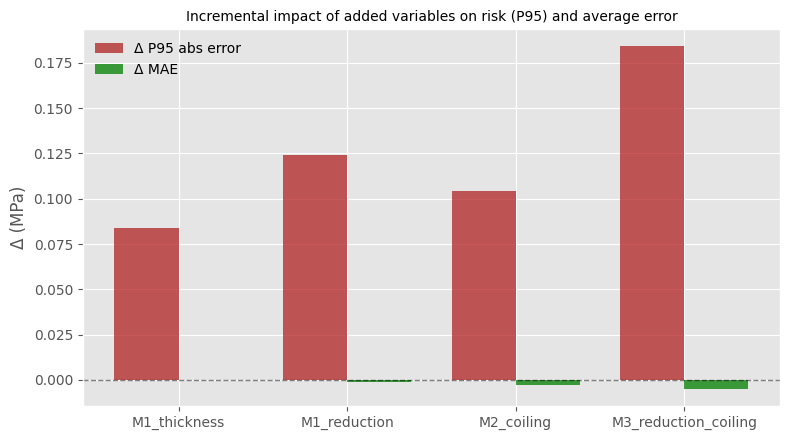

In [17]:
fig, ax = plot_incremental_deltas(delta_df)
plt.tight_layout()
plt.show()

### 5.5 Error Distribution: Baseline vs. Extended Model

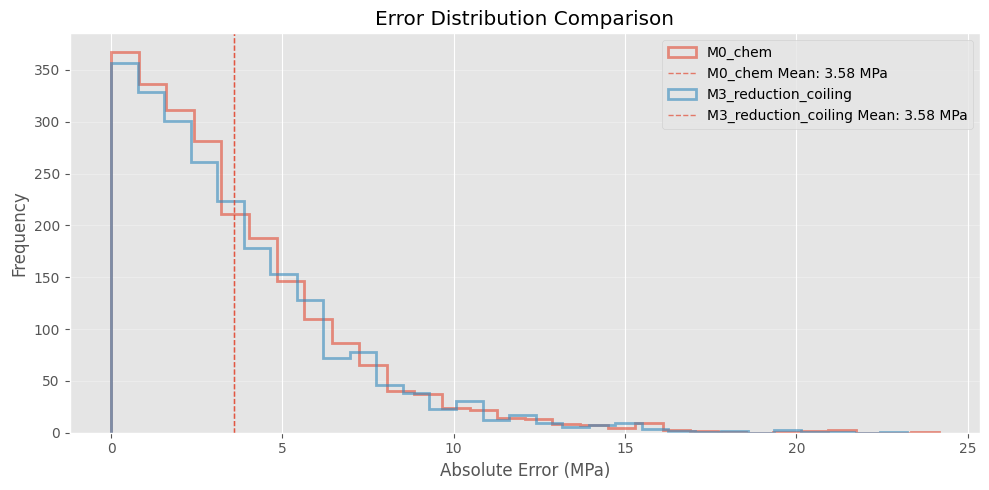

In [18]:
fig, ax = compare_error_distributions(
    screening_results=screening_results,
    models=['M0_chem', 'M3_reduction_coiling'],
)
plt.tight_layout()
plt.show()

## 6. Interpretation: What the Results Mean


### Key Findings

**No candidate variable demonstrates robust, defensible improvement over the chemistry-only baseline:**

1. **Central Tendency (MAE):**  
   Marginal improvements (< 0.01 MPa) are inconsistent across folds and do not justify added complexity.

2. **Tail Risk (P95 Absolute Error):**  
   **All** process variables either maintain or **worsen** tail error. This is the critical finding.

3. **Fold-Level Stability:**  
   Performance differences are not consistently reproduced across validation folds, suggesting improvements are fold-specific noise, not generalizable signal.

4. **Feature Representation:**  
   Alternative encodings of deformation (thickness vs. reduction %) behave similarly, with no clear advantage.

### Interpretation: Why Process Proxies Do Not Improve Performance

The absence of improvement is a meaningful result. It indicates that, at this level of abstraction, process information cannot be reliably exploited for prediction.

Rather, it suggests that:
- the selected proxies are too coarse to capture causal mechanisms
- their signal is partially entangled with chemistry
- their effect may be local, conditional, or nonlinear

Under the current representation,
these variables do not add stable information
beyond what is already encoded in composition.


### Engineering Implication

**For AA3105-O at heat level:**

- Chemistry **captures the dominant predictive signal** for UTS
- Evaluated process variables do **not** provide robust incremental value
- Remaining error (MAE ~3.6 MPa, P95 ~9.6 MPa) reflects **unmeasured process/microstructural effects**, not available measured variables
- **Conclusion: Chemistry-only modeling is defensible and appropriate for this system**

## 7. Decision Summary: Variable Inclusion Assessment

The following table summarizes variable inclusion decisions as they would be applied in an internal modeling standard.

| Variable                         | Decision     | Δ MAE      | Δ P95     | Rationale                                      |
|----------------------------------|--------------|------------|-----------|------------------------------------------------|
| Chemistry (Mn, Mg)               | **INCLUDE**  | baseline   | baseline  | Dominant explanatory signal                    |
| Final Thickness                  | **EXCLUDE**  | +0.000     | +0.028    | No improvement; tail risk worsens              |
| Reduction %                      | **EXCLUDE**  | -0.001     | +0.035    | Marginal MAE gain; tail risk worsens           |
| Coiling Temperature              | **EXCLUDE**  | -0.003     | +0.012    | Minimal signal; inconsistent across folds      |
| Reduction % + Coiling Temp       | **EXCLUDE**  | -0.005     | +0.032    | Combined complexity; tail risk increases       |


**CONCLUSION:** 

> Chemistry-only modeling is the defensible choice for AA3105-O UTS estimation

## 8. Limitations & Scope Boundaries

This study is subject to explicit scope limitations:

- **System scope:** AA3105-O only. Results do not generalize to other alloys without validation.
- **Domain scope:** Chemistry domain bounded by observed historical data. Extrapolation unsupported.
- **Measurement scope:** 'Available variables' tested reflect only what was measured. Unmeasured mechanisms remain unexplained.
- **Temporal scope:** Within a 6-month production window. Drift over longer timescales is possible.

**Future work** should:
- Test variable screening across 2–3 additional alloy systems
- Evaluate whether conclusions hold under longer temporal windows
- Consider whether additional unmeasured process variables (grain size, texture) would change findings

Accordingly, SC04 should be read as a boundary-setting exercise, not as an indictment of process-aware modeling.

**Key Takeaway**

SC04 demonstrates that disciplined modeling includes the ability to stop adding variables.

For AA3105-O, chemistry alone defines a stable and defensible UTS envelope at heat level. Recognizing where information ends is as important as extracting what is available.

This clarity enables SC05 to shift focus from prediction to decision design.